# Setting

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import xlrd

from datetime import datetime, timedelta
from pandas import DataFrame
import datetime

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt


!pip install selenium
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, Image
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException,StaleElementReferenceException

plt.style.use('seaborn')

# map
import folium
from folium import plugins
import json

# 데이콘 plotly 업로드를 위한 코드
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

#그래프 한글 출력을 위한 코드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install git+https://github.com/python-visualization/branca.git@master

    
# openAPI
import requests, bs4
import pandas as pd
from lxml import html
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote

# 경고처리
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
# 필요한 라이브러리 설치
!pip install html_table_parser
!pip install --upgrade html5lib==1.0b1
!pip install replace

import re
import math as m
import matplotlib.font_manager as fm
from bs4 import BeautifulSoup
from urllib.request import urlopen
from html_table_parser import parser_functions as parser
from google.colab import drive

import glob
import sys
from google.colab import drive
drive.mount('/content/drive')


plotly color
https://stackoverflow.com/questions/59732422/plotly-what-color-cycle-does-plotly-express-follow
그래프자료
https://ichi.pro/ko/plotly-expressleul-sayonghan-sigaghwa-pogwaljeog-in-gaideu-258792796523351

# Data Load & 전처리

#### 항공기별 연료효율

In [9]:
drive.mount('/content/drive')
# 웹 크롤링
url = 'https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft'
result = urlopen(url)
html = result.read()
soup = BeautifulSoup(html, 'html.parser')
temp = soup.find_all('table')

# 테이블 데이터 정리

df = []

for i in range(3, 6): #list_flights = ['short-haul', 'medium-haul', 'long-haul']
    p = parser.make2d(temp[i])
    df.append(pd.DataFrame(p[1:], columns=p[0]))

short_h = df[0]     # short_haul: For flights of 1,000 nmi (1,900 km)
medium_h = df[1]    # medium_haul: For flights of 1,750–3,400 nmi (3,240–6,300 km)
long_h = df[2]      # long_haul: For flights of 4,650–7,200 nmi (8,610–13,330 km)

## csv 데이터 읽어오기
airplane_list = pd.read_csv('/content/drive/MyDrive/21-국토교통/data/한국공항공사_항공기 보유현황_20200918.csv', encoding='euc-kr')

## 전처리
airplane_list['기 종 별'] = airplane_list['기 종 별'].str.replace('A', 'Airbus A')
airplane_list['기 종 별'] = airplane_list['기 종 별'].str.replace('B', 'Boeing ')
airplane_list['기 종 별'] = airplane_list['기 종 별'].str.split(',')
airplane_list = airplane_list[(airplane_list['구분'] == '여객기')]

for i in range(len(airplane_list)):         # 기종별 셀에 여러 항공기 종류가 들어가있어서 분리 --> 기종1, 기종2, 기종3, 기종4
    j = 0
    for j in range(len(airplane_list.at[i, '기 종 별'])):
        airplane_list.at[i, '기종' + str(j + 1)] = airplane_list.at[i, '기 종 별'][j]

airplane_list = airplane_list.fillna('')    # NaN 값 처리

del airplane_list['기 종 별']               # 필요없는 컬럼 삭제

def cal_max_fuel(df, airplane_list):        # 찐 함수
    distance = 1900
    fuelPerSeat = 'Fuel efficiency per seat'

    if 'Sector' in list(df.columns):
        df['Sector (km)'] = df['Sector'].str.findall(r"[\d+']").str.join('')
        df['Sector (km)'] = pd.to_numeric(df['Sector (km)'].str[4:])
        distance = df['Sector (km)']
        fuelPerSeat = 'Fuel per seat'


    df.sort_values(by=fuelPerSeat)  # df 비행에서 효율이 좋은 기종 정렬

    # 교집합으로 모든 기종 모음
    flight_list = list(set(airplane_list['기종1']) | set(airplane_list['기종2']) | set(airplane_list['기종3']))

    # 국내 항공사가 가진 df_haul 여객기에서 연료 효율이 높은 순
    df_sorted = df[df['Model'].isin(flight_list)]       # 거리에 따라 운행하는 기종 다름
    df_sorted = df_sorted.copy()
    df_sorted[fuelPerSeat] = df_sorted[fuelPerSeat].str.split(' ').str[0]
    df_sorted['Unit Fuel'] = df[(fuelPerSeat)].str.extract('(\d+\.\d+)')
    df_sorted['Unit Fuel'] = pd.to_numeric(df_sorted['Unit Fuel'])
    df_sorted['Fuel of maximum distance (L)'] = pd.to_numeric(df_sorted['Unit Fuel']) / 100 * distance
    df_sorted = df_sorted.sort_values(by=fuelPerSeat)

    return df_sorted # 0000km를 운행하는 동안 이정도의 연료가 소모된다.



# 운행거리에 따라 연료효율이 좋은 항공기 정렬
short_list = cal_max_fuel(short_h, airplane_list)    # short_haul: For flights of 1,000 nmi (1,900 km)
medium_list = cal_max_fuel(medium_h, airplane_list)   # medium_haul: For flights of 1,750–3,400 nmi (3,240–6,300 km)
long_list = cal_max_fuel(long_h, airplane_list)     # long_haul: For flights of 4,650–7,200 nmi (8,610–13,330 km)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 과거 전염병(sars, mers)시기 항공 데이터

In [10]:
def mergeAirport(years, massdata, csvName):
    list_col = [' ', '운항_도착', '운항_출발', '운항_합계', '여객_도착', '여객_출발', '여객_합계', '화물_도착', '화물_출발', '화물_합계']
    index_air = []
    for year in years:      #결과: 2001_1, 2001_2, ...
        for i in range(1,13):
            if str(year)=='2021' and i>7: break
            index_air.append(year+'_'+str(i))
    
    data = pd.DataFrame()
    for fname in massdata: pass
    for f in massdata:  #데이터 수합
        df = pd.read_excel(f)
        df.columns = list_col
        data = data.append(df.loc[len(df)-1])
    del data[list_col[0]]   #필요없는 열 삭제
    data.index = index_air  #인덱스 재설정
    data = data.T

    data.to_csv(csvName)
    
    
# 2001-2003 국내공항 통계 (단위: 편, 명, 톤)  -> air_sars.csv

years = ['2001', '2003', '2002']
airport_sars = sorted(glob.glob('/content/drive/MyDrive/21-국토교통/data/air_sars/항공통계_국내공항별*')) 
mergeAirport(years, airport_sars, 'air_sars.csv')


# 2014-2016 국내공항 통계 (단위: 편, 명, 톤)  -> air_mers.csv

years = ['2014', '2015', '2016']
airport_mers = sorted(glob.glob('/content/drive/MyDrive/21-국토교통/data/air_mers/항공통계_국내공항별*'))
mergeAirport(years, airport_mers, 'air_mers.csv')


# 2019-2021(07) 국내공항 통계 (단위: 편, 명, 톤) -> air_covid.csv

years = ['2019', '2020', '2021']
airport_covid = sorted(glob.glob('/content/drive/MyDrive/21-국토교통/data/air_covid19/항공통계_국내공항별*'))
mergeAirport(years, airport_covid, 'air_covid.csv')


#### 공항 온실가스(2011-2020)

In [ ]:
# 한국공항공사_공항 온실가스 # https://www.data.go.kr/data/3050602/openapi.do
# xml 데이터 파이썬으로 불러오기: https://greendreamtrre.tistory.com/268 (상세 설명 참고) > 이런식으로 다른 xml 데이터 파싱 가능!
# url 분리
xmlUrl = 'http://openapi.airport.co.kr/service/rest/EpiDataService/getEpiGhDataService' # 서비스 url
My_API_Key = unquote('UpSuGvk5OK9ji2y%2BaPbuQaxNYL2hTyiqkMLMgj2UFa%2Fuc6l0kg3huYJ5KM6SwwI%2FyHS1QO4MLHgOuoGbu2IwZQ%3D%3D') #인증키

queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('edate') : '2021'
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
airportgas = pd.DataFrame(rowList, columns=nameList)

airportgas.rename(columns = {'fuel1' : '직접온실가스', 'fuel2' : '간접온실가스', 'totalTco2e' : '총합', 'yyyy' : '년도'}, inplace = True)
airportgas = airportgas[['년도', '직접온실가스', '간접온실가스', '총합']]
airportgas

,년도,직접온실가스,간접온실가스,총합
0,2011,12806,109058,121864
1,2012,10914,100180,111094
2,2013,12395,94610,107006
3,2014,11744,73687,85432
4,2015,12573,110581,123154
5,2016,12670,68032,80702
6,2017,14136,72983,87119
7,2018,12461,72092,84554
8,2019,11929,71607,83537
9,2020,10386,59371,69758


#### 전국공항 수송실적통계(201601-202112) 

In [ ]:
# 한국공항공사_전국공항 수송실적통계 #https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=3034194
xmlUrl = 'http://openapi.airport.co.kr/service/rest/totalAirportStatsService/getAirportStats' # 서비스 url
My_API_Key = unquote('UpSuGvk5OK9ji2y%2BaPbuQaxNYL2hTyiqkMLMgj2UFa%2Fuc6l0kg3huYJ5KM6SwwI%2FyHS1QO4MLHgOuoGbu2IwZQ%3D%3D') #인증키

# 2016
queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('startDePd') : '201601', #검색시작월 201601~201612
        quote_plus('endDePd') : '201612' 
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
transport_2016 = pd.DataFrame(rowList, columns=nameList)

# 단위 -> 화물: KG, 여객: 명, 운항: 건
transport_2016.rename(columns = {'airport' : '공항명', 'arrcargo' : '도착 화물(KG)', 'arrflgt' : '도착 운항 편수', 'arrpassenger' : '도착 여객 인원수',
                                'depcargo' : '출발 화물(KG)', 'depflgt' : '출발 운항 편수', 'deppassenger' : '출발 여객 인원수', 'subcargo' : '화물 소계', 
                                'subflgt' : '운항편수 소계', 'subpassenger' : '여객 인원 소계' }, inplace = True)


# 2017
queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('startDePd') : '201701', #검색시작월 201701~201801
        quote_plus('endDePd') : '201712' 
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
transport_2017 = pd.DataFrame(rowList, columns=nameList)

# 단위 -> 화물: KG, 여객: 명, 운항: 건
transport_2017.rename(columns = {'airport' : '공항명', 'arrcargo' : '도착 화물(KG)', 'arrflgt' : '도착 운항 편수', 'arrpassenger' : '도착 여객 인원수',
                                'depcargo' : '출발 화물(KG)', 'depflgt' : '출발 운항 편수', 'deppassenger' : '출발 여객 인원수', 'subcargo' : '화물 소계', 
                                'subflgt' : '운항편수 소계', 'subpassenger' : '여객 인원 소계' }, inplace = True)


# 2018
queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('startDePd') : '201801', #검색시작월 201801~201812
        quote_plus('endDePd') : '201812' 
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
transport_2018 = pd.DataFrame(rowList, columns=nameList)

# 단위 -> 화물: KG, 여객: 명, 운항: 건
transport_2018.rename(columns = {'airport' : '공항명', 'arrcargo' : '도착 화물(KG)', 'arrflgt' : '도착 운항 편수', 'arrpassenger' : '도착 여객 인원수',
                                'depcargo' : '출발 화물(KG)', 'depflgt' : '출발 운항 편수', 'deppassenger' : '출발 여객 인원수', 'subcargo' : '화물 소계', 
                                'subflgt' : '운항편수 소계', 'subpassenger' : '여객 인원 소계' }, inplace = True)


# 2019
queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('startDePd') : '201901', #검색시작월 201901~201912
        quote_plus('endDePd') : '201912' 
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
transport_2019 = pd.DataFrame(rowList, columns=nameList)

# 단위 -> 화물: KG, 여객: 명, 운항: 건
transport_2019.rename(columns = {'airport' : '공항명', 'arrcargo' : '도착 화물(KG)', 'arrflgt' : '도착 운항 편수', 'arrpassenger' : '도착 여객 인원수',
                                'depcargo' : '출발 화물(KG)', 'depflgt' : '출발 운항 편수', 'deppassenger' : '출발 여객 인원수', 'subcargo' : '화물 소계', 
                                'subflgt' : '운항편수 소계', 'subpassenger' : '여객 인원 소계' }, inplace = True)


# 2020
queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('startDePd') : '202001', #검색시작월 202001~202012
        quote_plus('endDePd') : '202012' 
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
transport_2020 = pd.DataFrame(rowList, columns=nameList)

# 단위 -> 화물: KG, 여객: 명, 운항: 건
transport_2020.rename(columns = {'airport' : '공항명', 'arrcargo' : '도착 화물(KG)', 'arrflgt' : '도착 운항 편수', 'arrpassenger' : '도착 여객 인원수',
                                'depcargo' : '출발 화물(KG)', 'depflgt' : '출발 운항 편수', 'deppassenger' : '출발 여객 인원수', 'subcargo' : '화물 소계', 
                                'subflgt' : '운항편수 소계', 'subpassenger' : '여객 인원 소계' }, inplace = True)


# 2021
queryParams = '?' + urlencode( # 필수항목, 필수는 메뉴얼 확인
    {
        quote_plus('serviceKey') : My_API_Key,    # 서비스키
        quote_plus('startDePd') : '202101', #검색시작월 202101~202112
        quote_plus('endDePd') : '202112' #현재까지
     }
)

response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
# xmlobj    # 디버깅용

rows = xmlobj.findAll('item')
columns = rows[0].find_all()

rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        if i == 0:
            nameList.append(columns[j].name)
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []
    
transport_2021 = pd.DataFrame(rowList, columns=nameList)

# 단위 -> 화물: KG, 여객: 명, 운항: 건
transport_2021.rename(columns = {'airport' : '공항명', 'arrcargo' : '도착 화물(KG)', 'arrflgt' : '도착 운항 편수', 'arrpassenger' : '도착 여객 인원수',
                                'depcargo' : '출발 화물(KG)', 'depflgt' : '출발 운항 편수', 'deppassenger' : '출발 여객 인원수', 'subcargo' : '화물 소계', 
                                'subflgt' : '운항편수 소계', 'subpassenger' : '여객 인원 소계' }, inplace = True)

transport_2021.tail()


## 전처리 ##
# 각 데이터 별 총계 행 삭제
transport_2016 = transport_2016.drop([transport_2016.index[15]])
transport_2017 = transport_2017.drop([transport_2017.index[15]])
transport_2018 = transport_2018.drop([transport_2018.index[15]])
transport_2019 = transport_2019.drop([transport_2019.index[15]])
transport_2020 = transport_2020.drop([transport_2020.index[15]])
transport_2021 = transport_2021.drop([transport_2021.index[15]])

# year 정보 추가
transport_2016['year'] = '2016'
transport_2017['year'] = '2017'
transport_2018['year'] = '2018'
transport_2019['year'] = '2019'
transport_2020['year'] = '2020'
transport_2021['year'] = '2021'

# 자료 통합 및 형변환
transports = pd.concat([transport_2016,transport_2017,transport_2018,transport_2019,transport_2020,transport_2021], ignore_index=True)
transports[['도착 화물(KG)', '도착 운항 편수', '도착 여객 인원수', '출발 화물(KG)', '출발 운항 편수', '출발 여객 인원수', '화물 소계', '운항편수 소계', '여객 인원 소계']] = transports[['도착 화물(KG)', '도착 운항 편수', '도착 여객 인원수', '출발 화물(KG)', '출발 운항 편수', '출발 여객 인원수', '화물 소계', '운항편수 소계', '여객 인원 소계']].apply(pd.to_numeric)

transports

,공항명,도착 화물(KG),도착 운항 편수,도착 여객 인원수,출발 화물(KG),출발 운항 편수,출발 여객 인원수,화물 소계,운항편수 소계,여객 인원 소계,year
0,김포,137042802,72968,12545594,137662652,73298,12497494,274705454,146266,25043088,2016
1,김해,105328834,49672,7445398,80194143,49686,7455417,185522977,99358,14900815,2016
2,제주,133099621,86316,14846593,158394159,86427,14860771,291493780,172743,29707364,2016
3,대구,12939420,8552,1256582,11401149,8537,1276550,24340569,17089,2533132,2016
4,광주,6263719,5398,807921,8554377,5394,805854,14818096,10792,1613775,2016
...,...,...,...,...,...,...,...,...,...,...,...
85,진주,110,1,54,0,1,51,110,2,105,2021
86,포항,175621,524,40587,178675,524,43114,354296,1048,83701,2021
87,군산,393888,670,74866,368057,670,77274,761945,1340,152140,2021
88,원주,197674,334,35021,177528,334,35236,375202,668,70257,2021


#### 기상청 온실가스 관측자료_시계열 (2016~2020, 2017 누락)

In [ ]:
# 기상청_온실가스 관측자료  # https://www.data.go.kr/data/15050672/fileData.do

#2016
df_gas_2016_ori = pd.read_csv('C:/Users/user/Desktop/국토교통공모전/안면도_온실가스_DAY/ENV_GGSS_DAY_2016.csv', encoding='euc-kr')
df_gas_2016_ori.head()
df_gas_2016_ori.info()

## NaN 결측값 각 월 평균으로 채우기위해 월평균 체크 ##
df_gas_2016 = df_gas_2016_ori.copy()
df_gas_2016['일시'] = pd.to_datetime(df_gas_2016['일시'])
m = df_gas_2016['일시'].dt.month
result = df_gas_2016.groupby(m).mean()

# 월별 평균
result.index = pd.date_range('1/1/2016', '12/31/2016', freq='MS').strftime('%B')
result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   지점                                365 non-null    int64  
 1   일시                                365 non-null    object 
 2   평균 이산화탄소(CO2) 배경대기농도(ppm)         68 non-null     float64
 3   평균 메탄(CH4) 배경대기농도(ppm)            224 non-null    float64
 4   평균 아산화질소(N2O) 배경대기농도(ppm)         237 non-null    float64
 5   평균 염화불화탄소11(CFC11) 배경대기농도(ppm)    224 non-null    float64
 6   평균 염화불화탄소12(CFC12) 배경대기농도(ppm)    259 non-null    float64
 7   평균 염화불화탄소113(CFC113) 배경대기농도(ppm)  161 non-null    float64
 8   평균 육불화황(SF6) 배경대기농도(ppm)          224 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 25.8+ KB


,지점,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm)
January,132,411.058333,1966.392000,329.417391,242.893750,524.945455,70.033333,9.396429
February,132,412.017647,1964.427586,329.584000,240.214286,517.844444,NaN,9.279310
March,132,413.578571,1968.006897,329.982759,NaN,NaN,48.550000,9.212500
April,132,415.166667,1964.253571,331.022222,230.472727,511.725926,48.000000,9.665517
May,132,414.400000,1965.930435,330.915789,235.284211,522.733333,72.394118,9.683333
June,132,404.700000,1955.826667,330.400000,238.094118,531.732143,73.066667,9.876923
July,132,403.733333,1928.045455,330.159091,237.384615,533.387097,73.296552,9.382353
August,132,NaN,1942.566667,330.326923,241.847059,530.726667,73.704545,9.218519
September,132,406.200000,1986.542857,330.796000,236.577778,514.937500,71.257895,9.287500
October,132,408.450000,1988.692308,330.400000,243.842857,534.034483,72.711111,NaN


- 2월 평균 염화불화탄소113(CFC113) 배경대기농도(ppm)
- 3월 평균 염화불화탄소11(CFC11) 배경대기농도(ppm) , 평균 염화불화탄소12(CFC12) 배경대기농도(ppm) 
- 8월 평균 이산화탄소(CO2) 배경대기농도(ppm)
- 10월 평균 육불화황(SF6) 배경대기농도(ppm)
- 12월 평균 아산화질소(N2O) 배경대기농도(ppm)
- NaN 값으로 해당 month는 측정값이 없음
- 따라서 12월을 제외한 NaN 값은 전/후 달의 평균으로 채우고 12월은 2017년 온실가스 자료가 없으므로 2016년 10월과 11월 평균값으로 채운다

In [ ]:
gas_2016 = df_gas_2016_ori.copy()
gas_2016['일시'] = gas_2016['일시'].apply(lambda _: str(_))
gas_2016['year'] = gas_2016['일시'].str[:4]
gas_2016['month'] = gas_2016['일시'].str[5:7]
gas_2016['day'] = gas_2016['일시'].str[8:]

# NaN값 월별 평균으로 채우기
gas_2016.describe()
gas_2016['평균 이산화탄소(CO2) 배경대기농도(ppm)'] = gas_2016['평균 이산화탄소(CO2) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 이산화탄소(CO2) 배경대기농도(ppm)'].transform('mean'))
gas_2016['평균 메탄(CH4) 배경대기농도(ppm)'] = gas_2016['평균 메탄(CH4) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 메탄(CH4) 배경대기농도(ppm)'].transform('mean'))
gas_2016['평균 아산화질소(N2O) 배경대기농도(ppm)'] = gas_2016['평균 아산화질소(N2O) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 아산화질소(N2O) 배경대기농도(ppm)'].transform('mean'))
gas_2016['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] = gas_2016['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].transform('mean'))
gas_2016['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] = gas_2016['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].transform('mean'))
gas_2016['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] = gas_2016['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].transform('mean'))
gas_2016['평균 육불화황(SF6) 배경대기농도(ppm)'] = gas_2016['평균 육불화황(SF6) 배경대기농도(ppm)'].fillna(gas_2016.groupby('month')['평균 육불화황(SF6) 배경대기농도(ppm)'].transform('mean'))

gas_2016.tail()

,지점,일시,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm),year,month,day
360,132,2016-12-27,415.2,1975.2,NaN,241.225,539.881481,73.391667,9.3,2016,12,27
361,132,2016-12-28,413.9,1970.9,NaN,241.225,539.881481,73.391667,9.4,2016,12,28
362,132,2016-12-29,414.6,1975.2,NaN,225.800,514.900000,73.391667,9.3,2016,12,29
363,132,2016-12-30,413.9,1978.5,NaN,220.900,496.100000,73.391667,8.9,2016,12,30
364,132,2016-12-31,413.9,1999.8,NaN,228.900,489.500000,73.391667,8.7,2016,12,31


In [ ]:
# 각 열 별로 하나의 month에 대해 통으로 결측이 존재하므로 value를 이용하여 딕셔너리 형태로 입력
values = {'평균 이산화탄소(CO2) 배경대기농도(ppm)':(403.733333 + 406.200000)/2, '평균 아산화질소(N2O) 배경대기농도(ppm)':(330.400000 + 329.250000)/2
          , '평균 염화불화탄소11(CFC11) 배경대기농도(ppm)':(240.214286 + 230.472727)/2, '평균 염화불화탄소12(CFC12) 배경대기농도(ppm)':(517.844444 + 511.725926)/2
          , '평균 염화불화탄소113(CFC113) 배경대기농도(ppm)':(70.033333 + 48.550000)/2, '평균 육불화황(SF6) 배경대기농도(ppm)':(9.287500 + 10.000000)/2} 
gas_2016.fillna(value=values, inplace=True) 

# 하루 total 온실가스 열 생성
gas_2016['총 평균 온실가스'] = gas_2016['평균 이산화탄소(CO2) 배경대기농도(ppm)'] + gas_2016['평균 메탄(CH4) 배경대기농도(ppm)'] + gas_2016['평균 아산화질소(N2O) 배경대기농도(ppm)'] + gas_2016['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] + gas_2016['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] + gas_2016['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] + gas_2016['평균 육불화황(SF6) 배경대기농도(ppm)']
gas_2016 = gas_2016[['일시', '평균 이산화탄소(CO2) 배경대기농도(ppm)', '평균 메탄(CH4) 배경대기농도(ppm)', '평균 아산화질소(N2O) 배경대기농도(ppm)', '평균 염화불화탄소11(CFC11) 배경대기농도(ppm)', '평균 염화불화탄소12(CFC12) 배경대기농도(ppm)', '평균 염화불화탄소113(CFC113) 배경대기농도(ppm)', '평균 육불화황(SF6) 배경대기농도(ppm)', '총 평균 온실가스']]
gas_2016

,일시,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm),총 평균 온실가스
0,2016-01-01,411.058333,1977.900,329.417391,242.89375,524.945455,70.033333,9.8,3566.048263
1,2016-01-02,411.058333,1981.700,329.417391,242.89375,524.945455,70.033333,9.8,3569.848263
2,2016-01-03,411.058333,1966.392,331.200000,242.89375,524.945455,70.033333,9.8,3556.322871
3,2016-01-04,411.058333,2001.500,329.417391,242.89375,524.945455,70.033333,9.3,3589.148263
4,2016-01-05,411.058333,1958.800,330.000000,242.89375,524.945455,70.033333,9.2,3546.930871
...,...,...,...,...,...,...,...,...,...
360,2016-12-27,415.200000,1975.200,329.825000,241.22500,539.881481,73.391667,9.3,3584.023148
361,2016-12-28,413.900000,1970.900,329.825000,241.22500,539.881481,73.391667,9.4,3578.523148
362,2016-12-29,414.600000,1975.200,329.825000,225.80000,514.900000,73.391667,9.3,3543.016667
363,2016-12-30,413.900000,1978.500,329.825000,220.90000,496.100000,73.391667,8.9,3521.516667


In [ ]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 2018~2020년 위의 과정 반복 ## 

# 2018
df_gas_2018_ori = pd.read_csv('C:/Users/user/Desktop/국토교통공모전/안면도_온실가스_DAY/ENV_GGSS_DAY_2018.csv', encoding='euc-kr')
df_gas_2018 = df_gas_2018_ori.copy() # 월평균 체크 데이터

# 2019
df_gas_2019_ori = pd.read_csv('C:/Users/user/Desktop/국토교통공모전/안면도_온실가스_DAY/ENV_GGSS_DAY_2019.csv', encoding='euc-kr')
df_gas_2019 = df_gas_2019_ori.copy() # 월평균 체크 데이터

# 2020
df_gas_2020_ori = pd.read_csv('C:/Users/user/Desktop/국토교통공모전/안면도_온실가스_DAY/ENV_GGSS_DAY_2020.csv', encoding='euc-kr')
df_gas_2020 = df_gas_2020_ori.copy() # 월평균 체크 데이터

In [ ]:
## NaN 결측값 각 월 평균으로 채우기위해 월평균 체크 ##

# 2018
df_gas_2018['일시'] = pd.to_datetime(df_gas_2018['일시'])
m = df_gas_2018['일시'].dt.month
result_2018 = df_gas_2018.groupby(m).mean()

result_2018.index = pd.date_range('1/1/2018', '12/31/2018', freq='MS').strftime('%B') # 월별 평균


# 2019
df_gas_2019['일시'] = pd.to_datetime(df_gas_2019['일시'])
m = df_gas_2019['일시'].dt.month
result_2019 = df_gas_2019.groupby(m).mean()

result.index = pd.date_range('1/1/2019', '12/31/2019', freq='MS').strftime('%B') # 월별 평균


# 2020
df_gas_2020['일시'] = pd.to_datetime(df_gas_2020['일시'])
m = df_gas_2020['일시'].dt.month
result_2020 = df_gas_2020.groupby(m).mean()

result_2020.index = pd.date_range('1/1/2020', '12/31/2020', freq='MS').strftime('%B') # 월별 평균

In [ ]:
result_2018

,지점,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm)
January,132,418.910000,1976.456087,332.396296,227.169565,503.162963,69.928000,9.733333
February,132,419.085500,1984.390000,332.192857,227.132143,503.303571,70.046429,9.725000
March,132,422.441600,1989.787742,333.383871,227.950000,504.226667,70.295833,9.782353
April,132,420.710800,1967.180000,332.986667,229.457143,505.270000,70.410714,9.813043
May,132,418.255000,1956.667500,333.116129,230.340741,504.990323,70.488462,9.892857
June,132,413.539333,1977.816667,333.510000,230.657692,504.803333,70.489655,9.883333
July,132,412.310000,1897.344286,332.810714,228.070000,503.896774,70.187097,9.738095
August,132,407.156250,1920.583529,332.964516,227.554545,503.590323,70.176667,9.756250
September,132,408.817500,1986.603929,332.641379,227.559259,499.846667,69.640000,9.893750
October,132,414.960000,1976.237667,332.516129,228.067857,499.906452,69.690323,9.891667


In [ ]:
result_2019

,지점,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm)
일시,,,,,,,,
1,132,421.703560,1993.780024,332.232909,231.333545,NaN,71.015953,10.083004
2,132,423.153147,1998.718603,332.898720,231.877879,NaN,70.962725,10.114250
3,132,422.011671,1985.243815,333.306869,231.961187,NaN,70.901813,10.146037
4,132,421.625870,1980.538246,333.807633,232.370027,NaN,70.786090,10.271019
5,132,420.782974,1980.593188,333.755809,229.979399,499.356493,69.631175,10.445193
6,132,416.234967,1996.950622,334.822466,229.678047,497.564268,69.263895,10.558163
7,132,412.684526,1929.957963,333.911138,226.778502,496.361749,68.893505,10.387469
8,132,404.029224,1995.155251,334.079781,226.154420,496.319225,68.887145,10.324563
9,132,413.282942,2003.605636,334.626304,226.951545,498.874206,69.460553,10.361840


- 1월~4월 평균 염화불화탄소12(CFC12) 배경대기농도(ppm) 값이 없음 -> 2018년과 2020년의 평균으로 채우기

In [ ]:
result_2020

,지점,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm)
January,132,424.391997,2019.422604,334.429044,226.882570,499.228011,68.150991,10.425236
February,132,423.439606,2010.165624,334.707816,226.474509,498.809057,68.021586,10.411701
March,132,423.729679,1995.763068,334.676251,224.572374,498.554508,68.434090,10.442397
April,132,423.863130,1979.892034,334.584802,224.216163,498.133583,68.231433,10.452736
May,132,423.940491,1992.024488,335.764741,224.200188,497.073172,68.479483,10.608709
June,132,417.608962,1998.289418,336.019538,223.786179,496.840204,69.056413,10.744508
July,132,413.992739,2009.786238,335.828999,222.842619,496.047542,69.109688,10.543228
August,132,414.303208,1892.819386,334.485749,221.986971,495.644644,68.914024,10.451350
September,132,415.403422,2036.544969,335.338994,223.113730,495.696252,69.019479,10.639261
October,132,418.428072,2020.654174,335.173683,223.496347,495.314597,68.753836,10.535818


- 1월~12월 평균 육불화황(SF6) 배경대기농도(ppm) 값이 없음 -> 9월과 10월의 평균으로 11월을 채우고 10월과 11월의 평균으로 12월 채우기

In [ ]:
## 2018~2020년 위의 과정 반복 ## 

# 2018
gas_2018 = df_gas_2018_ori.copy()
gas_2018['일시'] = gas_2018['일시'].apply(lambda _: str(_))
gas_2018['year'] = gas_2018['일시'].str[:4]
gas_2018['month'] = gas_2018['일시'].str[5:7]
gas_2018['day'] = gas_2018['일시'].str[8:]

gas_2018['평균 이산화탄소(CO2) 배경대기농도(ppm)'] = gas_2018['평균 이산화탄소(CO2) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 이산화탄소(CO2) 배경대기농도(ppm)'].transform('mean'))
gas_2018['평균 메탄(CH4) 배경대기농도(ppm)'] = gas_2018['평균 메탄(CH4) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 메탄(CH4) 배경대기농도(ppm)'].transform('mean'))
gas_2018['평균 아산화질소(N2O) 배경대기농도(ppm)'] = gas_2018['평균 아산화질소(N2O) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 아산화질소(N2O) 배경대기농도(ppm)'].transform('mean'))
gas_2018['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] = gas_2018['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].transform('mean'))
gas_2018['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] = gas_2018['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].transform('mean'))
gas_2018['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] = gas_2018['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].transform('mean'))
gas_2018['평균 육불화황(SF6) 배경대기농도(ppm)'] = gas_2018['평균 육불화황(SF6) 배경대기농도(ppm)'].fillna(gas_2018.groupby('month')['평균 육불화황(SF6) 배경대기농도(ppm)'].transform('mean'))

gas_2018['총 평균 온실가스'] = gas_2018['평균 이산화탄소(CO2) 배경대기농도(ppm)'] + gas_2018['평균 메탄(CH4) 배경대기농도(ppm)'] + gas_2018['평균 아산화질소(N2O) 배경대기농도(ppm)'] + gas_2018['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] + gas_2018['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] + gas_2018['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] + gas_2018['평균 육불화황(SF6) 배경대기농도(ppm)'] # 하루 total 온실가스 열 생성
gas_2018 = gas_2018[['일시', '평균 이산화탄소(CO2) 배경대기농도(ppm)', '평균 메탄(CH4) 배경대기농도(ppm)', '평균 아산화질소(N2O) 배경대기농도(ppm)', '평균 염화불화탄소11(CFC11) 배경대기농도(ppm)', '평균 염화불화탄소12(CFC12) 배경대기농도(ppm)', '평균 염화불화탄소113(CFC113) 배경대기농도(ppm)', '평균 육불화황(SF6) 배경대기농도(ppm)', '총 평균 온실가스']]
gas_2018


# 2019
gas_2019 = df_gas_2019_ori.copy()
gas_2019['일시'] = gas_2019['일시'].apply(lambda _: str(_))
gas_2019['year'] = gas_2019['일시'].str[:4]
gas_2019['month'] = gas_2019['일시'].str[5:7]
gas_2019['day'] = gas_2019['일시'].str[8:]

gas_2019['평균 이산화탄소(CO2) 배경대기농도(ppm)'] = gas_2019['평균 이산화탄소(CO2) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 이산화탄소(CO2) 배경대기농도(ppm)'].transform('mean'))
gas_2019['평균 메탄(CH4) 배경대기농도(ppm)'] = gas_2019['평균 메탄(CH4) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 메탄(CH4) 배경대기농도(ppm)'].transform('mean'))
gas_2019['평균 아산화질소(N2O) 배경대기농도(ppm)'] = gas_2019['평균 아산화질소(N2O) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 아산화질소(N2O) 배경대기농도(ppm)'].transform('mean'))
gas_2019['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] = gas_2019['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].transform('mean'))
gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] = gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].transform('mean'))
gas_2019['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] = gas_2019['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].transform('mean'))
gas_2019['평균 육불화황(SF6) 배경대기농도(ppm)'] = gas_2019['평균 육불화황(SF6) 배경대기농도(ppm)'].fillna(gas_2019.groupby('month')['평균 육불화황(SF6) 배경대기농도(ppm)'].transform('mean'))

gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].iloc[:31] = (503.162963 + 499.228011)/2 # 1월
gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].iloc[31:59] = (503.303571 + 498.809057)/2 # 2월
gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].iloc[59:90] = (504.226667 + 498.554508)/2 # 3월
gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].iloc[90:120] = (505.270000 + 498.133583)/2 # 4월

gas_2019['총 평균 온실가스'] = gas_2019['평균 이산화탄소(CO2) 배경대기농도(ppm)'] + gas_2019['평균 메탄(CH4) 배경대기농도(ppm)'] + gas_2019['평균 아산화질소(N2O) 배경대기농도(ppm)'] + gas_2019['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] + gas_2019['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] + gas_2019['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] + gas_2019['평균 육불화황(SF6) 배경대기농도(ppm)'] # 하루 total 온실가스 열 생성
gas_2019 = gas_2019[['일시', '평균 이산화탄소(CO2) 배경대기농도(ppm)', '평균 메탄(CH4) 배경대기농도(ppm)', '평균 아산화질소(N2O) 배경대기농도(ppm)', '평균 염화불화탄소11(CFC11) 배경대기농도(ppm)', '평균 염화불화탄소12(CFC12) 배경대기농도(ppm)', '평균 염화불화탄소113(CFC113) 배경대기농도(ppm)', '평균 육불화황(SF6) 배경대기농도(ppm)', '총 평균 온실가스']]
gas_2019


# 2020
gas_2020 = df_gas_2020_ori.copy()
gas_2020['일시'] = gas_2020['일시'].apply(lambda _: str(_))
gas_2020['year'] = gas_2020['일시'].str[:4]
gas_2020['month'] = gas_2020['일시'].str[5:7]
gas_2020['day'] = gas_2020['일시'].str[8:]

gas_2020['평균 이산화탄소(CO2) 배경대기농도(ppm)'] = gas_2020['평균 이산화탄소(CO2) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 이산화탄소(CO2) 배경대기농도(ppm)'].transform('mean'))
gas_2020['평균 메탄(CH4) 배경대기농도(ppm)'] = gas_2020['평균 메탄(CH4) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 메탄(CH4) 배경대기농도(ppm)'].transform('mean'))
gas_2020['평균 아산화질소(N2O) 배경대기농도(ppm)'] = gas_2020['평균 아산화질소(N2O) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 아산화질소(N2O) 배경대기농도(ppm)'].transform('mean'))
gas_2020['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] = gas_2020['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'].transform('mean'))
gas_2020['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] = gas_2020['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'].transform('mean'))
gas_2020['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] = gas_2020['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'].transform('mean'))
gas_2020['평균 육불화황(SF6) 배경대기농도(ppm)'] = gas_2020['평균 육불화황(SF6) 배경대기농도(ppm)'].fillna(gas_2020.groupby('month')['평균 육불화황(SF6) 배경대기농도(ppm)'].transform('mean'))

gas_2020['평균 육불화황(SF6) 배경대기농도(ppm)'].iloc[305:335] = (10.639261 + 10.535818)/2 # 11월
gas_2020['평균 육불화황(SF6) 배경대기농도(ppm)'].iloc[335:] = (10.535818 + ((10.639261 + 10.535818)/2))/2 # 12월

gas_2020['총 평균 온실가스'] = gas_2020['평균 이산화탄소(CO2) 배경대기농도(ppm)'] + gas_2020['평균 메탄(CH4) 배경대기농도(ppm)'] + gas_2020['평균 아산화질소(N2O) 배경대기농도(ppm)'] + gas_2020['평균 염화불화탄소11(CFC11) 배경대기농도(ppm)'] + gas_2020['평균 염화불화탄소12(CFC12) 배경대기농도(ppm)'] + gas_2020['평균 염화불화탄소113(CFC113) 배경대기농도(ppm)'] + gas_2020['평균 육불화황(SF6) 배경대기농도(ppm)'] # 하루 total 온실가스 열 생성
gas_2020 = gas_2020[['일시', '평균 이산화탄소(CO2) 배경대기농도(ppm)', '평균 메탄(CH4) 배경대기농도(ppm)', '평균 아산화질소(N2O) 배경대기농도(ppm)', '평균 염화불화탄소11(CFC11) 배경대기농도(ppm)', '평균 염화불화탄소12(CFC12) 배경대기농도(ppm)', '평균 염화불화탄소113(CFC113) 배경대기농도(ppm)', '평균 육불화황(SF6) 배경대기농도(ppm)', '총 평균 온실가스']]

In [ ]:
# 연평균
result_year = pd.concat([gas_2016,gas_2018,gas_2019,gas_2020], ignore_index=True)
result_year = result_year[['일시','총 평균 온실가스']]
result_year = result_year.set_index('일시')
year_mean = result_year['총 평균 온실가스'].rolling(window=365,  center=True).mean() #30일 평균

#### 시계열 운행여객화물 통계(2016~2021)

In [ ]:
# 항공통계_시계열통계_운행여객화물 # https://www.airport.co.kr/www/cms/frFlightStatsCon/timeSeriesStats.do?MENU_ID=1250#none
df_운행여객화물_2016_2021 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/시계열통계/시계열 통계_2016_2021.xlsx',engine = 'openpyxl', )
df_운행여객화물_2016_2021

df_운행여객화물_2016_2021 = pd.DataFrame(df_운행여객화물_2016_2021)
운행여객화물_2016_2021 = df_운행여객화물_2016_2021.copy()
운행여객화물_2016_2021["운항(편)도착"] = 운행여객화물_2016_2021["운항(편)도착"].replace(',', '', regex=True)
운행여객화물_2016_2021['운항(편)도착'] = pd.to_numeric(운행여객화물_2016_2021['운항(편)도착'])
운행여객화물_2016_2021["운항(편)출발"] = 운행여객화물_2016_2021["운항(편)출발"].replace(',', '', regex=True)
운행여객화물_2016_2021['운항(편)출발'] = pd.to_numeric(운행여객화물_2016_2021['운항(편)출발'])
운행여객화물_2016_2021["운항(편)계"] = 운행여객화물_2016_2021["운항(편)계"].replace(',', '', regex=True)
운행여객화물_2016_2021['운항(편)계'] = pd.to_numeric(운행여객화물_2016_2021['운항(편)계'])
운행여객화물_2016_2021["여객(명)도착"] = 운행여객화물_2016_2021["여객(명)도착"].replace(',', '', regex=True)
운행여객화물_2016_2021['여객(명)도착'] = pd.to_numeric(운행여객화물_2016_2021['여객(명)도착'])
운행여객화물_2016_2021["여객(명)출발"] = 운행여객화물_2016_2021["여객(명)출발"].replace(',', '', regex=True)
운행여객화물_2016_2021['여객(명)출발'] = pd.to_numeric(운행여객화물_2016_2021['여객(명)출발'])
운행여객화물_2016_2021["여객(명)계"] = 운행여객화물_2016_2021["여객(명)계"].replace(',', '', regex=True)
운행여객화물_2016_2021['여객(명)계'] = pd.to_numeric(운행여객화물_2016_2021['여객(명)계'])
운행여객화물_2016_2021["화물(톤)도착"] = 운행여객화물_2016_2021["화물(톤)도착"].replace(',', '', regex=True)
운행여객화물_2016_2021['화물(톤)도착'] = pd.to_numeric(운행여객화물_2016_2021['화물(톤)도착'])
운행여객화물_2016_2021["화물(톤)출발"] = 운행여객화물_2016_2021["화물(톤)출발"].replace(',', '', regex=True)
운행여객화물_2016_2021['화물(톤)출발'] = pd.to_numeric(운행여객화물_2016_2021['화물(톤)출발'])
운행여객화물_2016_2021["화물(톤)계"] = 운행여객화물_2016_2021["화물(톤)계"].replace(',', '', regex=True)
운행여객화물_2016_2021['화물(톤)계'] = pd.to_numeric(운행여객화물_2016_2021['화물(톤)계'])

'''is_2016 = 운행여객화물_2016_2021['연도'] == 2016
운행여객화물_2016 = 운행여객화물_2016_2021[is_2016]
운행여객화물_2016 = 운행여객화물_2016[['월','운항(편)계','여객(명)계','화물(톤)계']]
운행여객화물_2016'''

"is_2016 = 운행여객화물_2016_2021['연도'] == 2016\n운행여객화물_2016 = 운행여객화물_2016_2021[is_2016]\n운행여객화물_2016 = 운행여객화물_2016[['월','운항(편)계','여객(명)계','화물(톤)계']]\n운행여객화물_2016"

#### 국내선 노선별 통계 (2020.02 ~ 2021.07)

In [ ]:
# 국내선 노선별 통계 # https://kosis.kr/statisticsList/statisticsListIndex.do?menuId=M_01_01&vwcd=MT_ZTITLE&parmTabId=M_01_01&outLink=Y&parentId=M2.1;M2_25.2;#content-group
# 김포, 김해, 제주, 인천 노선
국내선_여객_노선 = pd.read_csv('C:/Users/user/Desktop/국토교통공모전/국내선_노선별_통계_여객_2020_2021.csv', encoding='euc-kr')

국내선_여객_노선 = 국내선_여객_노선.replace("-", 0)
국내선_여객_노선

국내선_여객_노선['2020. 02'] = pd.to_numeric(국내선_여객_노선['2020. 02'])
국내선_여객_노선['2020. 03'] = pd.to_numeric(국내선_여객_노선['2020. 03'])
국내선_여객_노선['2020. 04'] = pd.to_numeric(국내선_여객_노선['2020. 04'])
국내선_여객_노선['2020. 05'] = pd.to_numeric(국내선_여객_노선['2020. 05'])
국내선_여객_노선['2020. 06'] = pd.to_numeric(국내선_여객_노선['2020. 06'])
국내선_여객_노선['2020. 07'] = pd.to_numeric(국내선_여객_노선['2020. 07'])
국내선_여객_노선['2020. 08'] = pd.to_numeric(국내선_여객_노선['2020. 08'])
국내선_여객_노선['2020. 09'] = pd.to_numeric(국내선_여객_노선['2020. 09'])
국내선_여객_노선['2020. 10'] = pd.to_numeric(국내선_여객_노선['2020. 10'])
국내선_여객_노선['2020. 11'] = pd.to_numeric(국내선_여객_노선['2020. 11'])
국내선_여객_노선['2020. 12'] = pd.to_numeric(국내선_여객_노선['2020. 12'])
국내선_여객_노선['2021. 01'] = pd.to_numeric(국내선_여객_노선['2021. 01'])
국내선_여객_노선['2021. 02'] = pd.to_numeric(국내선_여객_노선['2021. 02'])
국내선_여객_노선['2021. 03'] = pd.to_numeric(국내선_여객_노선['2021. 03'])
국내선_여객_노선['2021. 04'] = pd.to_numeric(국내선_여객_노선['2021. 04'])
국내선_여객_노선['2021. 05'] = pd.to_numeric(국내선_여객_노선['2021. 05'])
국내선_여객_노선['2021. 06'] = pd.to_numeric(국내선_여객_노선['2021. 06'])
국내선_여객_노선['2021. 07'] = pd.to_numeric(국내선_여객_노선['2021. 07'])

국내선_여객_노선['2020_total'] = 국내선_여객_노선['2020. 02'] + 국내선_여객_노선['2020. 03'] +국내선_여객_노선['2020. 04'] +국내선_여객_노선['2020. 05'] +국내선_여객_노선['2020. 06'] +국내선_여객_노선['2020. 07'] +국내선_여객_노선['2020. 08'] +국내선_여객_노선['2020. 09'] +국내선_여객_노선['2020. 10'] +국내선_여객_노선['2020. 11'] +국내선_여객_노선['2020. 12'] 
국내선_여객_노선['2021_total'] = 국내선_여객_노선['2021. 02'] + 국내선_여객_노선['2021. 03'] +국내선_여객_노선['2021. 04'] +국내선_여객_노선['2021. 05'] +국내선_여객_노선['2021. 06'] +국내선_여객_노선['2021. 07'] +국내선_여객_노선['2021. 01']
국내선_여객_노선

,운항노선,2020. 02,2020. 03,2020. 04,2020. 05,2020. 06,2020. 07,2020. 08,2020. 09,2020. 10,...,2020. 12,2021. 01,2021. 02,2021. 03,2021. 04,2021. 05,2021. 06,2021. 07,2020_total,2021_total
0,김포-제주,820954,674876,686843,954193,1052734,1193015,1393448,915497,1281864,...,776922,626887,1000257,1178389,1349753,1371140,1417391,1338174,11081557,8281991
1,김포-김포,0,0,0,0,0,0,0,0,934,...,0,412,78,0,60,156,1142,0,2502,1848
2,김포-김해,164070,95845,126937,222271,304921,340711,353790,275722,401346,...,308657,298923,414635,447693,473622,504368,456622,463824,3014381,3059687
3,인천-제주,51,0,0,0,0,240,499,0,191,...,204,50,200,387,1531,161,608,1326,1809,4263
4,인천-인천,0,0,0,0,0,0,0,0,1904,...,0,0,0,0,410,0,0,0,4702,410
5,인천-김해,30477,6549,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37026,0
6,김해-제주,147898,117925,138112,210703,247559,265018,281078,189729,283502,...,164130,135727,248011,268538,304375,319320,299908,294356,2389677,1870235
7,김해-김해,0,0,0,0,0,0,0,1056,1074,...,0,506,0,0,0,196,0,0,3186,702


#### 항공 여객 수송(국내,국제) (2013 ~ 2020)

In [ ]:
# 항공 여객 수송(국내, 국제) # http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1255
df_국내국제_여객통계 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/국내_국제_여객통계.xlsx',engine = 'openpyxl', header = 2 )
df_국내국제_여객통계 = df_국내국제_여객통계.drop([4])

국내국제_여객통계 = df_국내국제_여객통계.transpose()
국내국제_여객통계


국내국제_여객통계 = 국내국제_여객통계.rename(columns=국내국제_여객통계.iloc[0])
국내국제_여객통계 = 국내국제_여객통계.drop(국내국제_여객통계.index[0])
국내국제_여객통계 = 국내국제_여객통계.rename_axis('year').reset_index()

국내국제_여객통계.columns = ['year','국제선여객수','국제선여객증감률','국내선여객수','국내선여객증감률']

국내국제_여객통계 = pd.DataFrame(국내국제_여객통계)
국내국제_여객통계

국내국제_여객통계["국제선여객수"] = 국내국제_여객통계["국제선여객수"].replace(',', '', regex=True)
국내국제_여객통계['국제선여객수'] = pd.to_numeric(국내국제_여객통계['국제선여객수'])
국내국제_여객통계["국내선여객수"] = 국내국제_여객통계["국내선여객수"].replace(',', '', regex=True)
국내국제_여객통계['국내선여객수'] = pd.to_numeric(국내국제_여객통계['국내선여객수'])

#### 항공 화물 수송(국내,국제) (2013 ~ 2020)

In [ ]:
# 항공 화물 수송(국내, 국제) # http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1256
df_국내국제_화물통계 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/국내_국제_화물통계.xlsx',engine = 'openpyxl', header = 2 )
df_국내국제_화물통계 = df_국내국제_화물통계.drop([4])

국내국제_화물통계=df_국내국제_화물통계.transpose()
국내국제_화물통계

국내국제_화물통계 = 국내국제_화물통계.rename(columns=국내국제_화물통계.iloc[0])
국내국제_화물통계 = 국내국제_화물통계.drop(국내국제_화물통계.index[0])
국내국제_화물통계 = 국내국제_화물통계.rename_axis('year').reset_index()

국내국제_화물통계.columns = ['year','국제선화물량','국제선화물증감률','국내선화물량','국내선화물증감률']

국내국제_화물통계 = pd.DataFrame(국내국제_화물통계)
국내국제_화물통계

국내국제_화물통계["국제선화물량"] = 국내국제_화물통계["국제선화물량"].replace(',', '', regex=True)
국내국제_화물통계['국제선화물량'] = pd.to_numeric(국내국제_화물통계['국제선화물량'])
국내국제_화물통계["국내선화물량"] = 국내국제_화물통계["국내선화물량"].replace(',', '', regex=True)
국내국제_화물통계['국내선화물량'] = pd.to_numeric(국내국제_화물통계['국내선화물량'])

#### 항공여객 이동 특성 (2019 ~ 2020)

In [ ]:
# 2019년_항공여객_이동특성_조사 # https://www.airportal.go.kr/knowledge/od/main/main.jsp

항공여객_이동_2019 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/2019년_항공여객_이동특성_교통수단.xlsx',engine = 'openpyxl' , header = 1)
항공여객_이동_2019.rename(columns = {"iDx": "ID", "SQ4": "이용공항", "QA1": "출발지역","QA1_1": "세부지역","QA3_1": "교통수단_1순위","QA3_2": "교통수단_2순위","QA3_3": "교통수단_3순위"}, inplace=True)

항공여객_이동_2019.dropna(subset=['교통수단_1순위'], inplace=True) # 교통수단 미기입 기준 결측행 제거
항공여객_이동_2019['이용공항'].unique()

## 전처리 ##
# 인천, 김해, 제주, 김포 공항만 남기기
idx_nm = 항공여객_이동_2019[(항공여객_이동_2019['이용공항'] == '무안공항') | (항공여객_이동_2019['이용공항'] == '대구공항') | (항공여객_이동_2019['이용공항'] == '청주공항')].index
항공여객_이동_2019 = 항공여객_이동_2019.drop(idx_nm)

항공여객_이동_2019

# 2020년_항공여객_이동특성_조사 # https://www.airportal.go.kr/knowledge/od/main/main.jsp

항공여객_이동_2020 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/2020년_항공여객_이동특성_교통수단.xlsx',engine = 'openpyxl' , header = 1 )
항공여객_이동_2020.rename(columns = {"NO": "ID", "SQ4": "이용공항", "QA1": "출발지역","QA1_1": "세부지역","QA3_1": "교통수단_1순위","QA3_2": "교통수단_2순위","QA3_3": "교통수단_3순위"}, inplace=True)

항공여객_이동_2020.dropna(subset=['교통수단_1순위'], inplace=True) # 교통수단 미기입 기준 결측행 제거
#항공여객_이동_2020['이용공항'].unique()

## 전처리 ##
# 인천, 김해, 제주, 김포 공항만 남기기
# idx_nm_2 = 항공여객_이동_2019[(항공여객_이동_2020['이용공항'] == '무안공항') | (항공여객_이동_2020['이용공항'] == '대구공항') | (항공여객_이동_2020['이용공항'] == '청주공항')].index
# 항공여객_이동_2020 = 항공여객_이동_2020.drop(idx_nm_2)

# 항공여객_이동_2020

#### 연도별 교통부문 온실가스 배출량 (2015 ~ 2018)

In [ ]:
# 연도별_온실가스_배출량 # https://www.kotems.or.kr/
연도별_온실가스_배출량_1518 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/연도별_온실가스_배출량_1518.xlsx',engine = 'openpyxl' )
연도별_온실가스_배출량_1518

data = { "부문" : ['도로','도로','도로','도로','철도','철도','철도','철도','항공','항공','항공','항공'],
         "배출량" : [연도별_온실가스_배출량_1518.iloc[1,2], 연도별_온실가스_배출량_1518.iloc[1,3], 연도별_온실가스_배출량_1518.iloc[1,4],연도별_온실가스_배출량_1518.iloc[1,5],
                 연도별_온실가스_배출량_1518.iloc[2,2], 연도별_온실가스_배출량_1518.iloc[2,3], 연도별_온실가스_배출량_1518.iloc[2,4],연도별_온실가스_배출량_1518.iloc[2,5],
                 연도별_온실가스_배출량_1518.iloc[3,2], 연도별_온실가스_배출량_1518.iloc[3,3], 연도별_온실가스_배출량_1518.iloc[3,4],연도별_온실가스_배출량_1518.iloc[3,5]],
         "year" : ['2015','2016','2017','2018','2015','2016','2017','2018','2015','2016','2017','2018']
}
온실가스_1518 = pd.DataFrame(data)
온실가스_1518

,부문,배출량,year
0,도로,8.887149e+07,2015
1,도로,9.278889e+07,2016
2,도로,9.225377e+07,2017
3,도로,1.008997e+08,2018
4,철도,2.497294e+06,2015
5,철도,2.583731e+06,2016
6,철도,1.872159e+06,2017
7,철도,2.728074e+06,2018
8,항공,1.614928e+06,2015
9,항공,1.750194e+06,2016


#### 연료별 온실가스 배출량 (2015 ~ 2018)

In [ ]:
# 연료별_온실가스_배출량 # https://www.kotems.or.kr/
연료별_온실가스_배출량_1518 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/연료별_온실가스_배출량_1518.xlsx',engine = 'openpyxl' )
연료별_온실가스_배출량_1518['구분'] = '구분'

# 들어가며

코로나19로 인한 팬데믹 상황은 정치, 경제, 문화 등 모든 측면에서 우리 사회의 패러다임을 급속도로 변화시키고 있다. 인구 밀집으로 인한 감염병의 확산을 막기 위해 '사회적 거리 두기' 지침을 시행함에 따라 사람들과 직접 대면하거나 접촉하지 않는 '언택트 사회' 로 나아가고 있는 것이 대표적이다(함충범, 2021). 이러한 언택트 패러다임은 항공 산업에 치명적인 타격을 입히고 있다. 국토교통부에서 발표한 항공교통량 통계에 따르면, 20년도 한 해 동안 우리나라 하늘길을 이용한 항공 교통량은 19년 대비 50.0% 감소한 42만 1천 대로 하루 평균 1,151대 정도의 비중을 차지하고 있다(대한민국 정책브리핑, 2021). 그러나 이는 국내선과 국제선 전체 교통량에 대한 통계로 국제선의 경우 변이 바이러스 확산 등 여파로 사실상 중단 상태가 지속되어 올해 상반기 국제선 여객은 지난해보다 90.8%가 감소하였다고 집계되었다. 이와 반대로 국내선 여객은 2019년 상반기보다 3.2% 증가한 통계량을 보이며 국내선은 코로나 이전의 수치로 회복되었다. 즉, 코로나19 장기화로 항공의 큰 부분을 차지하던 국제 여객의 수요가 줄어들며 수하물 수요도 함께 줄었지만 국내선 여객, 특히 제주 노선과 내륙 노선은 지난해보다 각각 31.5%, 126.7% 증가하였다(매일경제, 2021).

팬데믹 상황이 가져온 변화가 모두 부정적인 결과를 보이지는 않았다. 코로나19의 확산을 제어하기 위해 산업과 교통망, 기업들이 멈춰서면서 탄소배출량이 줄어들었다. EU 집행위원회의 발표에 따르면, 2020년 온실가스 배출량은 2019년 대비 13.3% 감소했으며, 특히 항공부문은 약 64.1%로 급격한 감소를 보였다(원문못찾음, 2021). 그렇다면 팬데믹 이후 항공부문 온실가스 배출량은 되면 어떻게 될까? 통근과 같은 일상적인 이동은 팬데믹 이후가 되면 팬데믹 이전 상태로 돌아가는 정도가 될 것으로 예측하고 있다. 그러나 여행의 경우, 스웨덴 룬드 대학교에소 지속가능성의 과학을 연구하는 니콜라스는 두가지 전망을 제시했다. 하나는 팬데믹으로 겪은 위기를 통해 사람들이 가족과 친구, 공동체의 건강과 안녕에 삶을 초점을 두어 온실가스 배출 감소를 지속하기 위해 노력한다는 것이다. 다른 하나는 사람들은 장거리 여행을 나중으로 미루고 있는 것으로 비행으로 발생하는 탄소 발생량이 큰 비중을 차지할 것이라는 전망이다. 이에 대해 국내외 국가들은 온실가스 감축 제도를 도입하며 환경을 지키기위한 움직임을 보이고 있다.

따라서 본 팀은 코로나19 팬데믹 이전과 이후 항공 이용률과 온실가스 배출량에 대한 분석을 진행하고 도출된 인사이트를 통해 온실가스 배출량 감소를 위한 항공 아이디어를 제안하고자 한다.

대한민국정책브리핑(2021.01.24). '20년 항공교통량 19년 대비 50% 감소…하루 평균 1,151대'. 국토교통부. https://www.korea.kr/news/pressReleaseView.do?newsId=156433334
연합뉴스(2021.07.15). '상반기 항공여객 작년보다 30%↓…국내선은 코로나 이전수준 회복'. 매일경제. https://www.mk.co.kr/news/politics/view/2021/07/682112/
BBCNEWS(2020.04.26). '코로나19: 코로나 사태는 환경에 지속적인 영향을 미칠까?'. 매일경제. https://www.bbc.com/korean/features-52430816

# 서론

### 1. 항공 이용

#### 항공업계 피해
코로나 팬데믹에 산업계 패닉…수출·내수 모두 붕괴 위기 (20년 3월)  
직격탄을 맞은 건 산업의 혈액순환을 담당하는 항공과 해운 업계다. 국제선 항공기 10대 중에 8대는 현재 이륙조차 못 하고 있다. 세계 120여 국가에서 한국발 입국을 제한하면서다. 지난달 항공여객은 550만명으로 전년 대비 44%나 급감했다. 김포공항 국제선 항공편은 최근 '0'을 기록했다. 대한항공 등 항공사는 무급 휴직을 시행 중이다.  
코로나19여파 실감…텅빈 공항에 항공승객 72% ‘뚝’ (20년 3월)  
국내 항공사의 3월(1일-12일) 항공승객 수가 지난해 같은 기간 보다 72% 급감한 것으로 나타났다.  
국내 8개 항공사의 3월 여객 수(국제·국내선)를 확인한 결과 이달(3월 1일-12일) 총 여객 수는 108만8989명으로 전년 같은 기간 388만1448명 보다 72%(279만2459명)나 줄었다.  
항공사별로 3월 여객수송실적을 보면 대한항공이 25만6986명으로 전년 104만574명 보다 75.3%(78만3588명) 감소했고, 아시아나항공은 27만2273명으로 전년 79만3677명 보다 65.7%(52만1404명) 줄었다.  
코로나19 탓에…항공사, 신용등급 하락 가시화 (20년 3월)

[2020결산 ③항공]코로나19에 사상 최대 위기…항공업계 지각변동 (20년 12월)  
국제선 여객 급감에 화물·국내선 등 활로 찾아
업계 구조재편 속도…대한-아시아나 통합 추진
---
코로나19 확산 이후 가장 큰 손해를 본 업계 중 하나인 항공 산업. 2020년 3월, 국내 8개 항공사의 여객수는 전년 대비 72%의 감소를 보였다.(아시아타임즈, 2020)


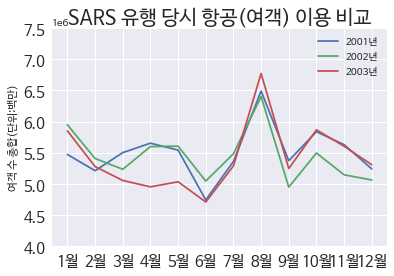

In [11]:
# 2001-2003 국내공항 여객 통계 비교 시각화

df_sars = pd.read_csv('air_sars.csv', encoding='utf-8-sig', index_col=0)
df_list = [[], [], []]
index_month = [i for i in range(1,13)]

for year in range(1, 4):        #쉼표 제거
    for month in range(1, 13):
        df_sars[str(year+2000)+'_'+str(month)] = df_sars[str(year+2000)+'_'+str(month)].str.replace(pat=r'[^\w]+', repl= r'', regex=True)

df_passenger = df_sars.loc['여객_합계']
df_passenger = df_passenger.astype('int')        #dtype 변경

df_2001 = df_passenger[0:12]
df_2001.index = index_month
df_2003 = df_passenger[12:24]
df_2003.index = index_month
df_2002 = df_passenger[24:36]
df_2002.index = index_month

df_passenger = pd.DataFrame([df_2001, df_2002, df_2003], index=['2001년', '2002년', '2003년'])

plt.rc('font', family='NanumBarunGothic')
df_passenger.T.plot(fontsize=15)
plt.xticks(np.arange(1, 13), labels=[str(i)+'월' for i in range(1,13)])
plt.yticks(np.arange(4, 8, 0.5)*10**6)
plt.title("SARS 유행 당시 항공(여객) 이용 비교", size=20)
plt.ylabel('여객 수 총합(단위:백만)')
plt.legend()
plt.show()

사스-코로나 바이러스(SARS coronavirus) 2002.11 ~ 2003.07 전세계 유행. 8096명 감염. 774명 사망. 우리나라의 경우 3명 감염. 첫번째 case 2003.04.25. 발생. 사망자 없음. WHO SARS 통계 

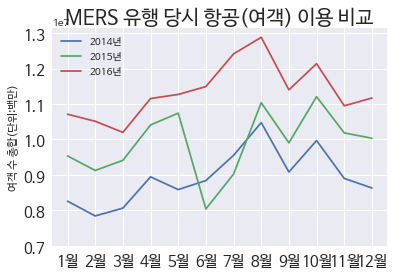

In [12]:
# 2014-2016 국내공항 여객 통계 비교 시각화

df_mers = pd.read_csv('air_mers.csv', index_col=0, encoding='utf-8-sig')

for year in range(14, 17):        #쉼표 제거
    for month in range(1, 13):
        df_mers[str(year+2000)+'_'+str(month)] = df_mers[str(year+2000)+'_'+str(month)].str.replace(pat=r'[^\w]+', repl= r'', regex=True)

df_passenger = df_mers.loc['여객_합계']
df_passenger = df_passenger.astype('int')        #dtype 변경

index_month = [i for i in range(1,13)]

df_2014 = df_passenger[0:12]
df_2014.index = index_month
df_2015 = df_passenger[12:24]
df_2015.index = index_month
df_2016 = df_passenger[24:36]
df_2016.index = index_month

df_passenger = pd.DataFrame([df_2014, df_2015, df_2016], index=['2014년', '2015년', '2016년'])

plt.rc('font', family='NanumBarunGothic')
df_passenger.T.plot(fontsize=15)
plt.xticks(np.arange(1, 13), labels=[str(i)+'월' for i in range(1,13)])
plt.yticks(np.arange(7, 14, 1)*10**6)
plt.title("MERS 유행 당시 항공(여객) 이용 비교", size=20)
plt.ylabel('여객 수 총합(단위:백만)')
plt.legend()
plt.show()

메르스-코로나 바이러스(MERS coronavirus) 2015.05 ~ 2015.07 유행. 182명 감염. 33명 사망. WHO MERS 통계  
![aa](멜.PNG)

→ 2002-2004년대보다 2014-2016년대 이용자 수가 약 두 배 가량 높아진 경향.  
→ 사스 그래프에서 보다시피 2003년 3-5월에서 다른 연도에 비해 낮은 이용객 수를 기록함. 사스 국내 첫 환자 발생이 4월 25일으로 이용객 감소와 비슷한 시기인 점을 미루어 보아 사스 유행은 항공 이용자 수와 상관관계가 있음.  
→ 메르스 그래프에서 2015년 6-7월 이용객 수는 성수기에도 불구하고 낮은 수치를 기록함. 메르스 유행이 15년 5월부터 7월까지 유행한 점을 짚어보면 메르스 유행 또한 항공 이용자 수와 상관관계가 있음. 
--- 
→ 따라서 전염병 유행은 항공산업 특히 여객 운행에 있어 부정적 영향을 미친다고 할 수 있음. 또한, 유행 이후엔 이용객 수가 다른 연도와 비슷한 추세로 돌아오는 것을 확인함. 더불어 코로나 종식 이후 여객 이용자 수는 앞으로도 꾸준히 증가할 것


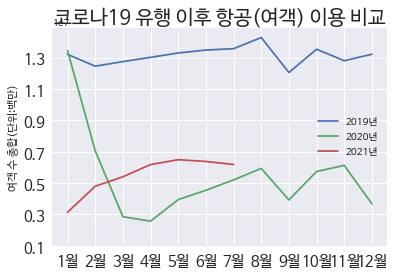

In [13]:
# 2019-2021(07) 국내공항 여객 통계 비교 시각화

df_covid = pd.read_csv('air_covid.csv', index_col=0, encoding='utf-8-sig')

for year in range(19, 22):        #쉼표 제거
    for month in range(1, 13):
        if year==21 and month>7: break
        df_covid[str(year+2000)+'_'+str(month)] = df_covid[str(year+2000)+'_'+str(month)].str.replace(pat=r'[^\w]+', repl= r'', regex=True)

df_passenger = df_covid.loc['여객_합계']
df_passenger = df_passenger.astype('int')        #dtype 변경

index_month = [i for i in range(1,13)]

df_2019 = df_passenger[0:12]
df_2019.index = index_month
df_2020 = df_passenger[12:24]
df_2020.index = index_month
df_2021 = df_passenger[24:36]
df_2021.index = index_month[0:7]

df_passenger = pd.DataFrame([df_2019, df_2020, df_2021], index=['2019년', '2020년', '2021년'])

plt.rc('font', family='NanumBarunGothic')
df_passenger.T.plot(fontsize=15)
plt.xticks(np.arange(1, 13), labels=[str(i)+'월' for i in range(1,13)])
plt.yticks(np.arange(1, 15, 2)*10**6)
plt.title("코로나19 유행 이후 항공(여객) 이용 비교", size=20)
plt.ylabel('여객 수 총합(단위:백만)')
plt.legend()
plt.show()

코로나 진행과정  
1차 유행: 2020.02. 신천지대구교회  
2차 유행: 2020.08. 광복절 서울 광화문 도심 집회와 서울 성북구 사랑제일교회를 두 축으로 하는 집단감염  
3차 유행: 2020.12-2021.01 일일 신규 확진자 300~400명대  
4차 유행: 2021.07- 진행중 일일 신규 확진자 1200명 이상  

### 2. 온실가스

앞에서 코로나 전/후 항공 이용률을 살펴보았다. 다음으로 코로나 전/후 온실가스에 대해 살펴보자.
먼저 온실가스는 지구온난화의 원인이 되는 대기 중 가스형태의 물질로 지표면에서 반사되는 복사에너지를 흡수해 지구온도를 높이는 온실효과를 일으킨다. 교토의정서에서 규제대상으로 규정한 6대 온실가스는 이산화탄소(CO₂), 메탄(CH₄), 아산화질소(N₂O), 수소불화탄소(HFCs), 과불화탄소(PFCs), 육불화황(SF·)이지만, 이 중 이산화탄소의 양이 가장 많아 온난화에 가장 큰 영향을 미친다. 온실가스는 원래 지구 온도 유지에 꼭 필요한 존재이지만, 산업화 이후 이산화탄소 등 온실가스가 과다배출되면서 온난화가 급속히 진행되고 있다.(환경부, 2021 접속)

In [ ]:
# 2016~2020년 온실가스 그래프
fig = go.Figure()
fig.add_trace(go.Scatter(x=gas_2016['일시'], y=gas_2016['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='one',name='2016년'))
fig.add_trace(go.Scatter(x=gas_2018['일시'], y=gas_2018['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='two',name='2018년'))
fig.add_trace(go.Scatter(x=gas_2019['일시'], y=gas_2019['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='three',name='2019년'))
fig.add_trace(go.Scatter(x=gas_2020['일시'], y=gas_2020['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='four',name='2020년',marker_color="#FFA15A"))

fig.add_scatter(x=year_mean.reset_index()['일시'], y=year_mean.reset_index()['총 평균 온실가스'], mode='lines',name='yearly',marker_color="black")

fig.update_layout(xaxis=dict(rangeslider=dict(autorange=True, range=["2016-01-01", "2020-12-31"],visible=True),type="date"))
fig.update_yaxes(range = [3300,3700])
fig.update_layout(template='plotly', title_text="2016년 ~ 2020년 온실가스 발생량 관측 추이", height=600 )
fig.show()

In [ ]:
# 2026~2020년 겹쳐그려서 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=gas_2016['일시'], y=gas_2016['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='one',name='2016년'))
fig.add_trace(go.Scatter(x=gas_2016['일시'], y=gas_2018['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='two',name='2018년'))
fig.add_trace(go.Scatter(x=gas_2016['일시'], y=gas_2019['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='three',name='2019년'))
fig.add_trace(go.Scatter(x=gas_2016['일시'], y=gas_2020['총 평균 온실가스'],hoverinfo='x+y',mode='lines',stackgroup='four',name='2020년' ,marker_color="#FFA15A"))

fig.update_layout(xaxis=dict(rangeslider=dict(autorange=True, range=["01-01", "12-31"],visible=True),type="date"))
fig.update_yaxes(range = [3300,3700])
fig.update_layout(template='plotly', title_text="2016년 ~ 2020년 온실가스 발생량 관측", height=600)
fig.show()

우리나라 기상청에서 온실가스 측정은 안면도와 울릉도에서 이루어지고 있다. 이 자료는 안면도에서 관측한 온실가스 발생량으로 2016 ~ 2020년 동안 관측한 자료이며, 2017년 자료는 누락되어 있는 상태이다.  
온실가스 추세선을 보면 매년 온실가스는 미세하게 증가하고 있음을 볼 수 있다.
---
코로나19로 항공 운항이 줄어들어, 항공업계에서 배출하는 온실가스의 양이 줄어들었음에도 전체 온실가스는 미세하게 증가함


#### 공항에서 배출하는 온실가스

In [ ]:
airportgas = airportgas.astype('float')

trace1 = go.Bar(x=airportgas["년도"], y=airportgas["직접온실가스"], name='직접온실가스')
trace2 = go.Bar(x=airportgas["년도"], y=airportgas["간접온실가스"], name='간접온실가스')
data = [trace1, trace2]
title = "공항 온실가스 배출량"
layout = go.Layout(template='plotly',title=title, barmode='stack')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

공항에서 배출하는 온실가스는 간접온실가스와 직접온실가스 두가지이며 간접 온실가스 배출량이 훨씬 많다.  
코로나19 발생(2020년 1월) 전후로 간접 온실가스의 감소량에 비해 직접 온실가스의 감소는 미미하다. 

![nn.](인전국제공항사_그린레포트_2021.PNG)
2021년 인천국제공항사에서 발간한 그린리포트에 따르면, 온실가스의 발생원에 따라 Scope 1~3으로 구분하고 있으며, 직접 온실가스의 경우 Scope1에 의해 발생하고 간접 온실가스는 Scope2와 Scop3에 의해 발생한다.  
따라서 앞서 보았던 코로나19로 감소하는 항공업계 이용률과 항공업계 온실가스 배출량에 비해 대기 중 온실가스 발생량이 증가하는 현상은 항공 외적인 요소의 영향이 크다고 볼 수 있다.

# 본론

### 항공 운행으로 발생하는 온실가스 배출량

In [14]:
def table_visual(df, x):        #시각화 함수
    plt.rc('font', family='NanumBarunGothic')
    plt.figure(figsize=(10,8))
    plt.barh(x, df['Unit Fuel'])
    plt.yticks(x, df['Model'])
    plt.xlabel('Unit Fuel (L/100km)')
    plt.ylabel('Model')
    plt.xlim(m.floor(min(df['Unit Fuel'])), m.ceil(max(df['Unit Fuel'])), 10)
    plt.show()

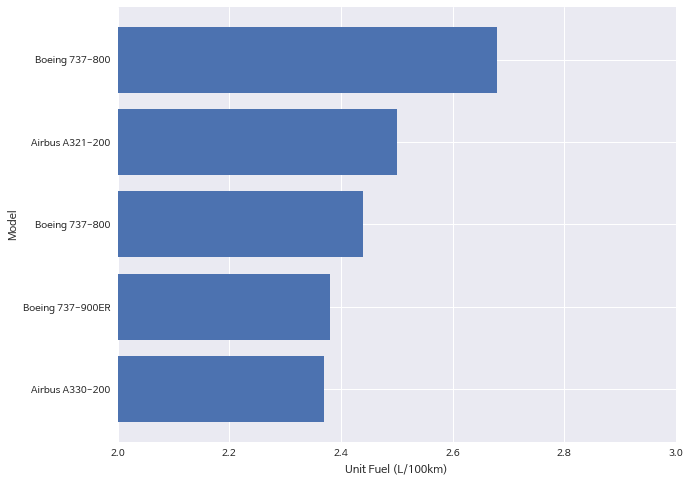

In [15]:
table_visual(short_list, np.arange(len(short_list)))

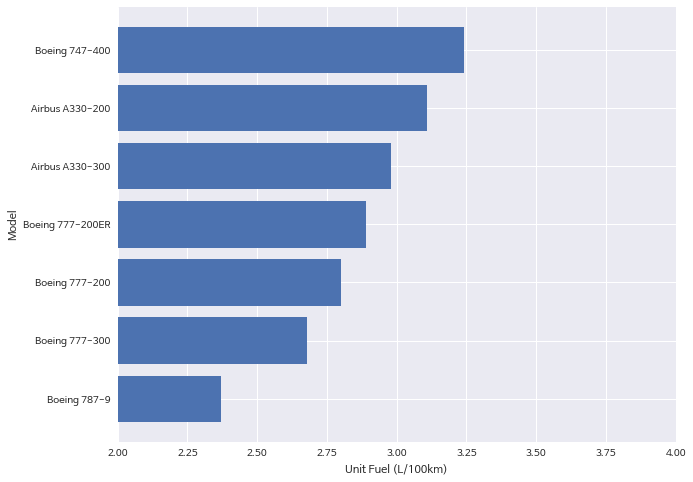

In [16]:
table_visual(medium_list, np.arange(len(medium_list)))

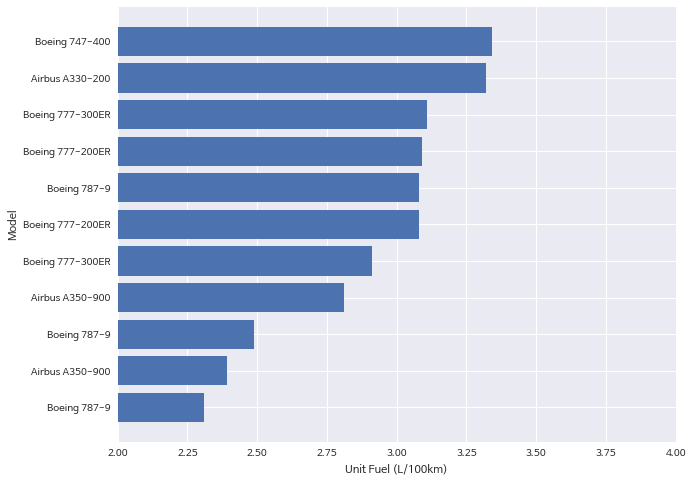

In [17]:
table_visual(long_list, np.arange(len(long_list)))

항공기 연료 소모량 (https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft)  
항공기 온실가스 배출량 계산 및 연료소모량당 온실가스 배출량 (https://www.eurocontrol.int/model/advanced-emission-model, https://www.eurocontrol.int/sites/default/files/content/documents/201807-european-aviation-fuel-burn-emissions-system-eea-v2.pdf)  
 
현재 우리나라에서 보유하고 있는 기종은 다음과 같다.   
'A321-200', 'A330-200', 'A330-300', 'A350-900', 'B737-800', 'B737-900ER', 'B747-400', 'B777-200', 'B777-200ER', 'B777-300', 'B777-300ER', 'B787-9'  
 
ICAO의 기종 분류 기준(2004)에 따르면, 우리나라에서 보유하고 있는 항공기는 C(85-189인승)와 E(262-608인승) 분류에 있다. 2009년 기준,  C의 세부기종인 A321, B737-800, B737-900는 평균 14,540 LTO로 101,333(ton CO2 eq)를 총 배출함. E의 세부기종인 A330-300, A330-200, B747-400, B777-200, B777-300은 평균 831 LTO로 12,657 ton CO2 eq를 배출했다. C1의 운항횟수(1000회)당 온실가스 배출량은 국내 6,814 ton CO2 eq, 국제 20,722 ton CO2 eq. E의 운항횟수당 온실가스는 국내 16,028 ton CO2 eq, 국제 14,809 ton CO2 eq였다.   

![dd](수식.png)

C(f1)은 aircraft-specific 첫 번째 추력 연료 소모 계수 [kg/min/kN for jet]이고 C(f2)은 두 번째 추력 연료 소모 계수 [kg/min/kN for jet]이다


### 항공 운행 외 교통에서 발생하는 온실가스 배출량

1인이 교통수단 이용시 발생하는 온실가스는 다음과 같다. 

![nn](http://mimg.segye.com/content/image/2019/10/30/20191030515783.jpg)
비행기의 온실가스 배출량(150명 기준)은 53.3㎏으로 휘발유 승용차와 비슷하다.   
경유와 하이브리드차가 배출량이 많고, 버스(28명 기준)는 10㎏으로 줄어든다.   
열차(900명 기준)는 1인당 온실가스 배출량은 5.9㎏에 불과해 가장 친환경적인 교통수단이다.

윤지로(2021.01.24). '급증하는 비행기는 온실가스 주범…‘플라이트 셰임’ 어때요 [연중기획 - 지구의 미래]'. 세계일보. http://m.segye.com/view/20191030514527

In [ ]:
fig = px.funnel(온실가스_1518, x='배출량', y='year', color='부문')
fig.update_layout(title={'text':'연도별 온실가스 배출량 : 도로 vs 철도 vs 항공', 'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly', font=dict(size=13), height=500)
fig.show()

In [ ]:
fig = px.funnel(연료별_온실가스_배출량_1518, x='비율(%)', y='구분', color='연료')
fig.update_layout(title={'text':'연료별 온실가스 배출량(%)', 'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly', font=dict(size=13), height=200)
fig.show()

#### 공항까지 가는 교통수단

Text(0.5, 1.0, '2019년 공항까지 이용한 교통수단')

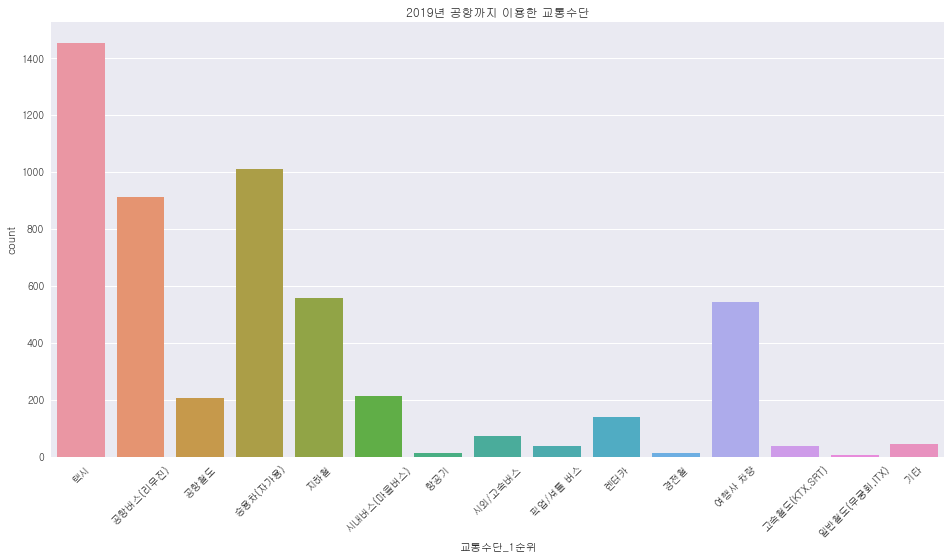

In [ ]:
from matplotlib import pyplot
import seaborn

a4_dims = (16, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.tick_params(axis='x', rotation=45)
sns.countplot(x = 항공여객_이동_2019['교통수단_1순위'], ax=ax).set_title('2019년 공항까지 이용한 교통수단')

In [ ]:
# 2020년_항공여객_이동특성_조사 # https://www.airportal.go.kr/knowledge/od/main/main.jsp

항공여객_이동_2020 = pd.read_excel('C:/Users/user/Desktop/국토교통공모전/2020년_항공여객_이동특성_교통수단.xlsx',engine = 'openpyxl' , header = 1 )
항공여객_이동_2020.rename(columns = {"NO": "ID", "SQ4": "이용공항", "QA1": "출발지역","QA1_1": "세부지역","QA3_1": "교통수단_1순위","QA3_2": "교통수단_2순위","QA3_3": "교통수단_3순위"}, inplace=True)

항공여객_이동_2020.dropna(subset=['교통수단_1순위'], inplace=True) # 교통수단 미기입 기준 결측행 제거
#항공여객_이동_2020['이용공항'].unique()

## 전처리 ##
# 인천, 김해, 제주, 김포 공항만 남기기
# idx_nm_2 = 항공여객_이동_2019[(항공여객_이동_2020['이용공항'] == '무안공항') | (항공여객_이동_2020['이용공항'] == '대구공항') | (항공여객_이동_2020['이용공항'] == '청주공항')].index
# 항공여객_이동_2020 = 항공여객_이동_2020.drop(idx_nm_2)

# 항공여객_이동_2020

Text(0.5, 1.0, '2020년 공항까지 이용한 교통수단')

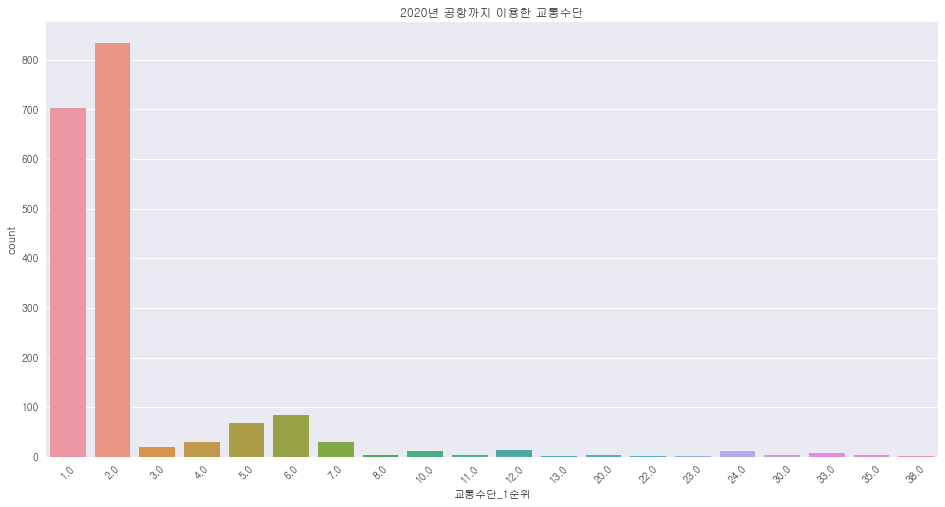

In [ ]:
a4_dims = (16, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.tick_params(axis='x', rotation=45)
sns.countplot(x = 항공여객_이동_2020['교통수단_1순위'], ax=ax).set_title('2020년 공항까지 이용한 교통수단')

설문지에 따르면 1번은 승용차(자가용), 2번은 택시로 2019년과 마찬가지로 1위와 2위는 자가용과 택시  
그러나 2019년에는 높은 이용률을 보였던 공항버스(리무진), 지하철, 여행사 차량의 경우 코로나19의 영향인지 이용량이 급감하였다.
> ![dd](설문지.PNG)

따라서 공항까지 이동하는 교통수단으로 온실가스 배출량이 가장 큰 자동차와 택시의 비율은 증가할 것으로 보인다.

In [ ]:
fig = px.line(운행여객화물_2016_2021, x="월", y="운항(편)계", 
             title='2016년~2021년 운항 추이',
             color='연도',
             line_group='연도',
             hover_name='연도',
             markers=True)

fig.show()

In [ ]:
fig = px.line(운행여객화물_2016_2021, x="월", y="여객(명)계", 
             title='2016년~2021년 여객 추이',
             color='연도',
             line_group='연도',
             hover_name='연도',
             markers=True)

fig.show()

In [ ]:
fig = px.line(운행여객화물_2016_2021, x="월", y="화물(톤)계", 
             title='2016년~2021년 화물 추이',
             color='연도',
             line_group='연도',
             hover_name='연도',
             markers=True)

fig.show()

In [ ]:
## 연도에 따른 각 공항별 화물/운항/여객인원 비교 ##
# 화물 소계
fig = px.funnel(transports, x='화물 소계', y='year', color='공항명')
fig.update_layout(title={'text':'2016 ~ 2021년 공항별 화물량 비교', 'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly', font=dict(size=13), height=500)
fig.show()

# 운항편수 소계
fig = px.funnel(transports, x='운항편수 소계', y='year', color='공항명')
fig.update_layout(title={'text':'2016 ~ 2021년 공항별 운항편수 비교', 'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly', font=dict(size=13), height=500)
fig.show()

# 여객 인원 소계
fig = px.funnel(transports, x='여객 인원 소계', y='year', color='공항명')
fig.update_layout(title={'text':'2016 ~ 2021년 공항별 여객 인원 비교', 'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly', font=dict(size=13), height=500)
fig.show()

#### 운항 / 여객 / 화물 의미
- (운항) = 여객기 + 화물기
- (여객) = 유임승객 + 무임승객 + 환승승객 (도착통과여객 제외)
- (화물) = 직화물 + 환적화물 + 우편물(수하물 제외)

코로나19의 영향으로 2020년부터 모든 공항의 운항, 여객, 화물량이 감소함  
눈에 띄는 특징으로, 먼저 화물의 경우 전반적으로 모든 공항이 감소하였으나 여객과 운항의 감소율과 비교해보았을 시 감소폭이 크지 않음  
이는 코로나19의 여파로 어느정도의 화물량은 줄었으나 코로나19 백신, 지원 물자 등의 이동은 계속되어 감소폭이 크지 않은 것으로 보임  
여객의 경우, 주로 국외 이동시 이용하는 인천 공항 여객이 급감하였고 국내 이동시 이용하는 김포, 제주는 상대적으로 감소폭이 작으며, 이는 국외 여행을 가지 못하는 국민의 여행 관심이 국내 여행으로 향한 것으로 보이며, 특히 '김포 <-> 제주' 이용량이 높은 것으로 보임

---
코로나19가 지속 됨에 따라 참아오던 여행 욕구는 점점 분출되고 있으며, 코로나19가 종식되어 활동의 제약이 풀리고 해외 여행이 상당 수준 회복될 때까지 국내 여행에 대한 관심은 줄어들지 않고 늘어날 것으로 보임


#### ▶▶코로나 종식 이전에 국내 여행량은 계속해서 증가할 것이며, 종식 이후에는 국내와 함께 국외 여행량이 증가할 것  


In [ ]:
# 코로나19 이후 공항별 여객 인원 비교
transports2 = transports.groupby(by=['공항명', 'year']).sum().reset_index() # grouby 
transports2.rename(columns = {"여객 인원 소계": "여객인원소계"}, inplace = True)


trace3 = go.Bar(x=transports2[transports2['year'] == '2020'].공항명, y=transports2[transports2['year'] == '2020'].여객인원소계, name='2020년')
trace4 = go.Bar(x=transports2[transports2['year'] == '2021'].공항명, y=transports2[transports2['year'] == '2021'].여객인원소계, name='2021년')

data = [trace3, trace4]
layout = go.Layout(title='코로나19 이후 공항별 여객 인원')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

코로나19 이후 여객 이용량은 김포, 김해, 제주가 압도적  
따라서 4개의 공항, 김포/김해/제주/인천을 위주로 분석을 진행한다.

### 국내선 노선 이용량 비교

In [ ]:
#pv_sum = case.filter(['province', 'confirmed']).groupby(['province']).sum().reset_index()
data = [go.Pie(labels=국내선_여객_노선['운항노선'], values=국내선_여객_노선['2020_total'],hole=.3)]
fig = go.Figure(data=data)
fig.update_layout(
    title={'text': "2020년 국내선 노선 비율", 'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly')
fig.update_traces(textposition='inside')
pyo.iplot(fig)

In [ ]:
data = [go.Pie(labels=국내선_여객_노선['운항노선'], values=국내선_여객_노선['2021_total'],hole=.3)]
fig = go.Figure(data=data)
fig.update_layout(
    title={'text': "2021년 국내선 노선 비율", 'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly')
fig.update_traces(textposition='inside')
pyo.iplot(fig)

김포-김해 운행 노선의 비율이 높아짐

In [ ]:
trace1 = go.Bar(x=국내국제_여객통계["year"], y=국내국제_여객통계["국내선여객수"], name='국내선 여객수')
trace2 = go.Bar(x=국내국제_여객통계["year"], y=국내국제_여객통계["국제선여객수"], name='국제선 여객수')

data = [trace1, trace2]
layout = go.Layout(template='plotly',title_text="연도별 항공여객 수송실적")
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

국내선 여객은 미미하게 감소, 국제선 여객은 급감

In [ ]:
trace3 = go.Bar(x=국내국제_화물통계["year"], y=국내국제_화물통계["국내선화물량"], name='국내선 화물량')
trace4 = go.Bar(x=국내국제_화물통계["year"], y=국내국제_화물통계["국제선화물량"], name='국제선 화물량')

data = [trace3, trace4]
layout = go.Layout(template='plotly',title_text="연도별 항공화물 수송실적")
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

따라서 국내선 여객 이용량은 계속해서 증가중이며, 김포 - 김해 노선이 큰 증가를 보이고 있다.  
이를 고려하여 김포 - 김해와 같이 항공 외 교통수단으로 충분히 갈 수 있는 경우 1인당 온실가스 배출량이 적은 철도/KTX의 이용을 제안하거나, 공항까지 가는 교통편의 온실가스 배출량을 고려한 친환경적인 움직임이 필요하다.

# 결론

코로나19 이전에 유행했던 전염병 사례 분석을 통해 포스트 코로나 시대의 종결 후 항공 업계의 이용량을 예측하고, 항공 온실가스 배출량을 기종별, 연도별 확인하며 공항 이용시 발생하는 교통수단의 온실가스와 이용 빈도를 확인함.  
이를 통해 얻은 인사이트는 다음과 같음.

1.


전염병 유행이 항공 산업 중 특히 여객 운행에 있어 부정적 영향을 미친다고 할 수 있음. 
또한, 전염병 유행 이후 항공 이용객 수가 다른 연도와 비슷한 추세로 돌아오는 것을 확인함. 

그러나 메르스 그래프를 통해 알 수 있듯, 매년 항공 이용객 수는 전년 대비 약 5%씩 증가(국토교통부, 2020)하는 추세를 보임. 따라서, 포스트 코로나 시대에 발생할 온실가스는 이전과 비슷하거나 혹은 더 늘어날 것이라 예측할 수 있음.

2.


코로나임에도 불구하고 국내선의 이용량은 계속해서 증가하는 추세이며 이들은 교통수단으로 1인당 온실가스 배출량이 높은 택시 및 자가용을 이용함. 또한, 가장 많이 이용하는 국내선은 제주-김포였으며, 김포-김해 노선의 경우 작년에 비해 이용량이 크게 상승함

따라서 코로나 상황에도 증가하는 공항 이용객과 이후 코로나 종결 후 폭발적으로 증가 할 미래의 공항 이용객들의 온실가스 배출량의 잠재성을 고려하여 공항 이용시 1인당 온실가스 배출량을 줄이는 방안이 필요하여 본 팀은 다음과 같은 서비스를 제안한다.

### 제안 1. 연료 효율이 좋은 항공기 활용

항공 온실가스 감축을 위해 연료 효율이 좋은 항공기 활용을 제안한다. 

특히 본론1에서 보인 운행거리에 따라 연료 효율이 달라지는 점을 고려하여 항공편 계획을 제안한다. 짧은 운행(~ 1900km)에서는 A330-200, B737-900ER, B737-800 순으로 효율이 높았으며, 중간 거리 운행(~6200km)에서는 B787-9, B777-300, B777-200 순으로 효율이 높았다.

마지막으로 장거리 운행(~12000km)에서는 B787-9, A350-900, B787-9 순서이다.

### 제안 2. 에코 스카이 예약 서비스

Fuel of maximum distance 컬럼을 바탕으로, 도착지까지 1인당 발생시키는 온실가스 배출량을 항공권 예매 과정 중 제공한다. 이때, 탄소발자국을 줄이기 위해 승객이 선택할 수 있는 옵션을 항공사에서 제시한다. 이때 옵션은 다음과 같다.
1. 자택(혹은 예매자의 현재 위치)에서 공항까지의 이동 중 추천하는 에코 교통 수단과 경로
    - 공항까지 가는 거리를 교통 수단별 온실가스 발생량으로 계산하여 이동 경로를 제공
        ![image.png](http://www.greenpostkorea.co.kr/news/photo/202006/117955_118938_1013.jpg)
        이한(2020.06.07). '[그린포스트 환경스쿨 ①] 자동차·비행기·기차...기후변화에 뭐가 덜 나쁠까'. 환경경제신문그린포스트코리아. http://www.greenpostkorea.co.kr/news/articleView.html?idxno=117955
2. 지구 지킴이 마일리지 기부 
3. 기내용품 일회용 사용여부 (ex. [ ]일회용품/[ ]항공사 제공 다회용품/[ ]개인용)
    1. [일회용품] 사탕수수 젓가락, 대나무 빨대 등 자연분해가 가능한 일회용품 제공 권장
    2. [다회용품] 공항 내부에 기내 반입 가능 다회용품 대여 서비스를 마련해 승객이 사용한 후 도착공항에서 수거하는 방식으로 운영할 수 있다.
    3. [개인용] 승객 스스로 수저와 텀블러 등을 준비할 수도 있다.
4. 시간에 구애받지 않는 승객이라면 기종별 온실가스 배출량이 달랐던 점을 활용해 효율적인 기종을 운행하는 항공편을 추천할 수 있다. 국내선 시간대별 운행하는 기종이 다르기 때문에, 국내 항공사들에 에코 기종의 확장을 요구하는 것 보다 승객이 스스로 에코 기종 운항 시간대를 이용하도록 제시한다.
    - 예를 들면, 김포-김해 행 항공편 중 승객 1인 기준 온실가스 배출량이 적은 기종을 우선적으로 운행 시간대를 추천하는 식이다. 

위 서비스는 비즈니스 승객 뿐만 아니라 단기성 휴가를 즐기러 떠나는 승객들에게도 탄소발자국에 대해 고민할 시간을 제공하는 데 의의가 있다.

본 게시물의 저작권은 Apache License v2.0을 따릅니다.

[참고문헌]  
박진서, 최성원, 김제철(2011). 항공수요에 따른 항공부문 온실가스 예측에 관한 연구.교통연구 18(3). 19-33.  
국토교통부(2012). 항공부문 온실가스 감축 국가이행계획 수립 연구. 한국교통연구원 최종보고서  
한국교통연구원(2015). 현안분석보고서_메르스(MERS-Dov)확산에 따른 항공수요변화. 한국교통연구원  
항공정책과(2020.01.29). '19년 항공여객 1억 2,337만명, 전년 대비 5% 증가. 국토교통부. https://www.molit.go.kr/USR/NEWS/m_71/dtl.jsp?lcmspage=78&id=95083478  
최인수(2020.03.16). 코로나 팬데믹에 산업계 패닉…수출·내수 모두 붕괴 위기. 노컷뉴스
https://www.nocutnews.co.kr/news/5308813  
고은결(2020.12.16). 코로나19에 사상 최대 위기…항공업계 지각변동 https://www.nocutnews.co.kr/news/5308813  

[사용한 데이터]  

|데이터명|연도|내용|출처|
|:---|:---|:---|:---|
|한국공항공사_항공기 보유현황_20200918 | 2020 | 국내 항공기 보유현황 확인 | 공공데이터포털 https://www.data.go.kr/data/15002708/fileData.do |
|항공통계_국내공항별 / 2002-2004, 2014-2016, 2019-2020(07) | 국내 여객 이용 추이 분석 | 인천국제공항공사 https://www.airport.kr/co/ko/cpr/statisticOfLocalAirport.do  |
|Wikipedia | Fuel economy in aircraft | 1981-2019 | 기종별 연료 효율 분석 https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft  |
|한국공항공사_공항 온실가스 | 2013-2020 | 공항 배출 온실가스 | 공공데이터포털 https://www.data.go.kr/data/3050602/openapi.do  |
|한국공항공사_전국공항 수송실적통계 | 2016-2021 | 전국공항 수송실적 / 공공데이터포털 https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=3034194  |
|기상청_온실가스 관측자료 | 2016-2020(2017누락)) | 온면도에서 관측한 대기중 온실가스 | 공공데이터포털 |  https://www.data.go.kr/data/15050672/fileData.do  |
| 항공통계_시계열통계_운행여객화물 | 2016-2021 | 운행,여객,화물량 시계열 | KAC 한국공항공사 - KOREA AIRPORTS CORPORATION https://www.airport.co.kr/www/cms/frFlightStatsCon/timeSeriesStats.do?MENU_ID=1250#none   |
| 국내선 노선별 통계 | 2020-2021 | 김해, 김포, 제주, 인천 노선 통계 | kosis https://kosis.kr/statisticsList/statisticsListIndex.do?menuId=M_01_01&vwcd=MT_ZTITLE&parmTabId=M_01_01&outLink=Y&parentId=M2.1;M2_25.2;#content-group |
| 항공 여객 수송(국내, 국제) | 2013-2020 | 항공 여객 수송량 | e-나라지표 http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1255 |
| 항공 화물 수송(국내, 국제) | 2013-2020 | 항공 화물 수송량 | e-나라지표 http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1256 |
| 2019년_항공여객_이동특성_조사 | 2019 | 2019년 공항 이용 교통수단 | airportal https://www.airportal.go.kr/knowledge/od/main/main.jsp|
| 2020년_항공여객_이동특성_조사 | 2020 | 2020년 공항 이용 교통수단 | airportal https://www.airportal.go.kr/knowledge/od/main/main.jsp |
| 연도별_온실가스_배출량 | 2015-2018 | 연도별 온실가스 배출량 | kotems https://www.kotems.or.kr/ |
| 연료별_온실가스_배출량 | 2015-2018 | 연료별 온실가스 배출량 | kotems https://www.kotems.or.kr/ |